In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder
import collections
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
from pathlib import Path
np.random.seed(42)
import tensorflow as tf
from sklearn.mixture import GaussianMixture # https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/

In [5]:
DATA_DIR = "data"
data_files = [str(filePath) for filePath in Path(DATA_DIR).glob("**/*") if filePath.is_file()]

In [6]:
data_files

['data/InvoiceExtract.csv',
 'data/PaymentsExtract.csv',
 'data/DebtorExtract.csv']

In [7]:
data_labels = ['Invoice','Payments','Debtor']
data_dict = {data_labels[i]: pd.read_csv(data_files[i]) for i in range(len(data_labels))}

In [8]:
debtor_df = data_dict['Debtor']
payment_df = data_dict['Payments']
invoice_df = data_dict['Invoice']

In [9]:
# Inner Join on Customer Key
a = debtor_df.merge(invoice_df)

In [10]:
# Inner Join on Invoice Key
b = a.merge(payment_df, on = 'InvoiceKey')

In [11]:
# Drop unnecessary columns
b = b.drop(['CustomerKey_x', 'ExtractDate'], axis = 1)

In [12]:
# Drop NA
b = b.dropna()

In [13]:
# Set date values to datetime
b["RaisedDate"] = pd.to_datetime(b["RaisedDate"])
b["DueDate"] = pd.to_datetime(b["DueDate"])
b["PaymentDate"] = pd.to_datetime(b["PaymentDate"])

In [14]:
# Reset Index
b = b.reset_index()

In [15]:
# Create onehot encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [16]:
# One Hot Encode Categorical Variables
# Statement Transaction Type
enc_df = pd.DataFrame(data = enc.fit_transform(b[['StatementTransactionType']]).toarray(), columns = enc.categories_)
b = b.join(enc_df)

print("Encoded statement transaction type.")

# Payment Type
enc_df = pd.DataFrame(data = enc.fit_transform(b[['PaymentType']]).toarray(), columns = enc.categories_)
b = b.join(enc_df)
print("Encoded payment type.")


# Is credit invoice
enc_df = pd.DataFrame(data = enc.fit_transform(b[['IsCreditInvoice']]).toarray(), columns = enc.categories_)
b = b.join(enc_df)
print("Encoded is credit invoice.")


#Postal code

#nc_df = pd.DataFrame(data = enc.fit_transform(b[[' PostcodeOuter']]).toarray(), columns = enc.categories_)
# = b.join(enc_df)
      
#rint("Encoded postal code.")

b=b.drop(["StatementTransactionType", "PaymentType", " PostcodeOuter", "IsCreditInvoice"], axis = 1)

Encoded statement transaction type.
Encoded payment type.
Encoded is credit invoice.


In [17]:
# Generate some variables for dates
b["PaymentPercentage"] =  b["PaymentValue"] / b["OriginalInvoiceAmount"]
b["DaysToDue"] = (b["DueDate"] - b["PaymentDate"]).astype('timedelta64[D]')
b["PaymentWindow"] = (b["DueDate"] - b["RaisedDate"]).astype('timedelta64[D]')

In [18]:
# Create x using only numerical columns
remove_cols = ["index", "CustomerKey_y", "InvoiceKey", "RaisedDate", "DueDate", "PaymentDate"]
x_cols = list(b.columns)
for i in remove_cols:
    x_cols.remove(i)
x = b[x_cols]

# Scale x
data = scale(x)

In [19]:
distortions = [] 
covariances = [] 
mapping1 = {} 
mapping2 = {} 
G = range(1,15) 

# Loop 10 times
for g in G: 
    #Building and fitting the model 
    GMModel = GaussianMixture(n_components=g, ).fit(data) 
    GMModel.fit(data)     
      
    distortions.append(sum(np.min(cdist(data, GMModel.means_, 
                      'cosine'),axis=1)) / data.shape[0]) 
    covariances.append(GMModel.covariances_) 
  
    mapping1[g] = sum(np.min(cdist(data, GMModel.means_, 
                 'cosine'),axis=1)) / data.shape[0] 
    mapping2[g] = GMModel.covariances_ 

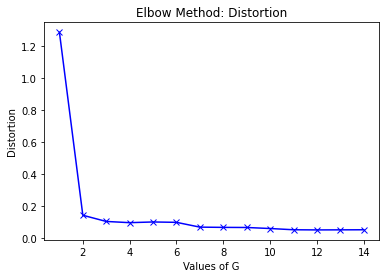

In [20]:
plt.plot(G, distortions, 'bx-') 
plt.xlabel('Values of G') 
plt.ylabel('Distortion') 
plt.title('Elbow Method: Distortion') 
plt.show() 

In [21]:
# Visualize the results on PCA-reduced data
pca = PCA(2)
reduced_data = pca.fit_transform(data)
GMModel = GaussianMixture(n_components=3, )
GMModel.fit(reduced_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [22]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

In [23]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [24]:
Z = GMModel.predict(np.c_[xx.ravel(), yy.ravel()])

In [25]:
Z

array([2, 2, 2, ..., 1, 1, 1])

In [26]:
Z = Z.reshape(xx.shape)

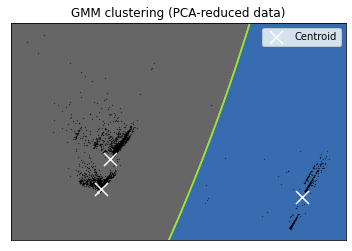

In [34]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Accent,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=0.5)
# Plot the centroids as a white X
means = GMModel.means_
plt.scatter(means[:, 0], means[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10, label = "Centroid")
plt.contour(xx,yy, Z)
plt.title('GMM clustering (PCA-reduced data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()